In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Dropout, Input
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.metrics import RootMeanSquaredError
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline

2022-06-15 11:57:41.225581: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-15 11:57:41.225596: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


TODO
 - windowing and composing datasets from all windows
 - dont use test pairs in train
 - if item is not represented in train set replace it with mean sales over shop (analyze this boys)
 - probably separate model for items
 - outliers
 - randoms
 - data doc
 - more convenient inference 
 - fill_value in pivot tables

In [2]:
# Import data
sales = pd.read_csv('../data/raw/sales_train.csv')
val = pd.read_csv('../data/raw/test.csv')
submit = pd.read_csv('../data/raw/sample_submission.csv')
shop_df = pd.read_csv('../data/raw/shops.csv')
item_df = pd.read_csv('../data/raw/items.csv')

In [3]:
CLIP_BOUND_LOW = 0.
CLIP_BOUND_HIGH = 20.
WINDOW_SIZE = 33

In [4]:
%%time
df = sales.groupby([
    'date_block_num',
    'item_id',
    'shop_id'
]).agg({'item_cnt_day': 'sum', 'item_price': 'mean'}).reset_index()
df = df[['date_block_num','item_id','shop_id','item_cnt_day', 'item_price']]
df['item_cnt_day'].clip(CLIP_BOUND_LOW, CLIP_BOUND_HIGH, inplace=True) 

CPU times: user 642 ms, sys: 25.8 ms, total: 667 ms
Wall time: 668 ms


### Composing Test Dataset

In [5]:
test_df = df.merge(val, on=['shop_id', 'item_id'], how='right')

#### Treating items for which we don't have info

In [6]:
items_with_no_data = val.loc[~val.item_id.isin(df.item_id.unique())].item_id.unique()
items_with_no_data.size

363

In [7]:
shops_to_avg = val.loc[val.item_id.isin(items_with_no_data)].shop_id.unique()
shops_to_avg.size

42

In [8]:
shops_avg = df.loc[df.shop_id.isin(shops_to_avg)].groupby(['date_block_num', 'shop_id']).agg({
    'item_price': 'mean',
    'item_cnt_day': 'mean'
}).reset_index()

In [9]:
isna_df = test_df.loc[test_df.date_block_num.isna(), ['item_id', 'shop_id', 'ID']]
test_df = test_df.loc[test_df.date_block_num.notna()]

In [10]:
isna_df['date_block_num'] = isna_df.apply(lambda _: list(range(34)), axis=1)
isna_df = isna_df.explode('date_block_num')

In [11]:
isna_df = isna_df.merge(shops_avg, on=['date_block_num', 'shop_id'], how='inner')
isna_df = isna_df[test_df.columns]

In [12]:
test_df.shape

(600159, 6)

In [13]:
test_df = pd.concat([test_df, isna_df], ignore_index=True)

In [14]:
test_df.shape

(3721528, 6)

### Composing Train Dataset

In [15]:
train_df = df.loc[~df.item_id.isin(val.item_id.unique()) | ~df.shop_id.isin(val.shop_id.unique())]

In [16]:
train_df.shape

(1008965, 5)

### Composing Val Dataset

In [17]:
train_pairs = train_df[['item_id', 'shop_id']].drop_duplicates()

In [18]:
train_pairs, valid_pairs = train_test_split(train_pairs, test_size=60000, random_state=2022)

In [19]:
train_pairs.shape, valid_pairs.shape

((252720, 2), (60000, 2))

In [20]:
valid_df = train_df.merge(valid_pairs, on=['item_id', 'shop_id'], how='inner')
train_df = train_df.merge(train_pairs, on=['item_id', 'shop_id'], how='inner')

In [21]:
valid_df.shape, train_df.shape

((193161, 5), (815804, 5))

### Scaling

In [22]:
# sales_scaler = MinMaxScaler()
# train_df['item_cnt_day'] = sales_scaler.fit_transform(train_df['item_cnt_day'].values.reshape(-1,1))
# valid_df['item_cnt_day'] = sales_scaler.transform(valid_df['item_cnt_day'].values.reshape(-1,1))
# test_df['item_cnt_day'] = sales_scaler.transform(test_df['item_cnt_day'].values.reshape(-1,1))


prices_scaler = MinMaxScaler()
train_df['item_price'] = prices_scaler.fit_transform(train_df['item_price'].values.reshape(-1,1))
valid_df['item_price'] = prices_scaler.transform(valid_df['item_price'].values.reshape(-1,1))
test_df['item_price'] = prices_scaler.transform(test_df['item_price'].values.reshape(-1,1))

### Pivoting

In [23]:
def get_matrix(df, index_col=None):
    if index_col is None:
        index_col = ['item_id','shop_id']

    sales_df = df.pivot_table(
        index=index_col,
        columns='date_block_num',
        values='item_cnt_day',
        fill_value=0
    )

    price_df = df.pivot_table(
        index=index_col,
        columns='date_block_num',
        values='item_price',
        fill_value=0
    )

    sales_mx = sales_df.values
    price_mx = price_df.values

    return np.dstack([sales_mx, price_mx])

In [25]:
%%time
train_inputs = get_matrix(train_df)
valid_inputs = get_matrix(valid_df)
test_inputs = get_matrix(test_df, index_col='ID')
# outputs = np.roll(sales_mx, shift=-1, axis=1)

CPU times: user 4.86 s, sys: 480 ms, total: 5.34 s
Wall time: 5.34 s


In [26]:
train_inputs.shape, valid_inputs.shape, test_inputs.shape

((252720, 34, 2), (60000, 34, 2), (214200, 34, 2))

In [76]:
train_inputs[:, :-1].shape, train_inputs[:, 1:, 0].shape

((252720, 33, 2), (252720, 33))

### Windowing

In [27]:
WINDOW_SIZE

33

[0 1 2 3 4 5 6 7 8 9] wsize=6
 - test - [3 4 5 6 7 8] [9]
 - inference - [4 5 6 7 8 9] [?]
 - train:
     - [0 1 2 3 4 5] [6]
     - [1 2 3 4 5 6] [7]
     - [2 3 4 5 6 7] [8]

In [129]:
max_seq_len = train_inputs.shape[1]
wsize = 28
windows = [train_inputs[:, i: i + wsize + 1] for i in range(max_seq_len - wsize)]

train_windows = np.vstack(windows[:-1])
test_window = windows[-1]
inference_window = test_inputs[:, -wsize:]

X_train, y_train = train_windows[:, :-1], train_windows[:, -1, 0]

X_test, y_test = test_window[:, :-1], test_window[:, -1, 0]

X_inference = inference_window

In [130]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_inference.shape

((1263600, 28, 2), (1263600,), (252720, 28, 2), (252720,), (214200, 28, 2))

In [ ]:
def get_train_xy(inputs, wsize=WINDOW_SIZE):
    max_seq_len = inputs.shape[1]
    X = []
    for i in range(max_seq_len - wsize):
        X.append(inputs[:, i:i + wsize + 1])
    
    X = np.vstack(X[-1:] if only_last else X)

    return X

In [61]:
def get_windowed_data(inputs, wsize=WINDOW_SIZE, only_last=False):
    max_seq_len = inputs.shape[1]
    X = []
    for i in range(max_seq_len - wsize):
        X.append(inputs[:, i:i + wsize + 1])
    
    X = np.vstack(X[-1:] if only_last else X)

    return X

### Define model

In [132]:
# Define the model layers
model_lstm = Sequential()
model_lstm.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(LSTM(16, return_sequences=True))
model_lstm.add(Dropout(0.5))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer="adam", loss='mse', metrics=[RootMeanSquaredError()])
print(model_lstm.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 28, 16)            1216      
                                                                 
 dropout_2 (Dropout)         (None, 28, 16)            0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                6272      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 7,521
Trainable params: 7,521
Non-trainable params: 0
_________________________________________________________________
None


In [125]:
model_lstm.layers[2].return_sequences = True

### Train model

X Train Shape:  (1516320, 28, 2)
X Valid Shape:  (360000, 28, 2)
y Train Shape:  (1516320,)
y Valid Shape:  (360000,)
Epoch 1/10
11847/11847 - 306s - loss: 0.1075 - root_mean_squared_error: 0.3279 - val_loss: 0.1103 - val_root_mean_squared_error: 0.3321 - 306s/epoch - 26ms/step
Epoch 2/10
11847/11847 - 286s - loss: 0.1058 - root_mean_squared_error: 0.3253 - val_loss: 0.1083 - val_root_mean_squared_error: 0.3291 - 286s/epoch - 24ms/step
Epoch 3/10
11847/11847 - 334s - loss: 0.1063 - root_mean_squared_error: 0.3261 - val_loss: 0.1078 - val_root_mean_squared_error: 0.3283 - 334s/epoch - 28ms/step
Epoch 4/10
11847/11847 - 397s - loss: 0.1058 - root_mean_squared_error: 0.3252 - val_loss: 0.1077 - val_root_mean_squared_error: 0.3282 - 397s/epoch - 33ms/step
Epoch 5/10
11847/11847 - 372s - loss: 0.1060 - root_mean_squared_error: 0.3256 - val_loss: 0.1067 - val_root_mean_squared_error: 0.3267 - 372s/epoch - 31ms/step
Epoch 6/10
11847/11847 - 349s - loss: 0.1053 - root_mean_squared_error: 0.324

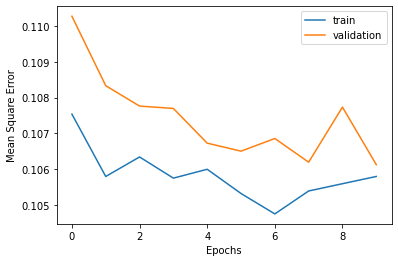

In [272]:
%%time
VALID = True
LSTM_PARAM = {"batch_size":128,
              "verbose":2,
              "epochs":10}

if VALID:
    
#     X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.10, random_state=1, shuffle=True)
    print("X Train Shape: ",X_train.shape)
    print("X Valid Shape: ",X_valid.shape)
    print("y Train Shape: ",y_train.shape)
    print("y Valid Shape: ",y_valid.shape)
    
    callbacks_list=[EarlyStopping(monitor="val_loss", min_delta=.0003, patience=3)]
    hist = model_lstm.fit(X_train, y_train,
                          validation_data=(X_valid, y_valid),
                          callbacks=callbacks_list,
                          **LSTM_PARAM)
#     pred = model_lstm.predict(X_test)

    # Model Evaluation
    best = np.argmin(hist.history['val_loss'])
    print(f'Optimal Epoch: {best}')
    print(f'Train Score: {hist.history["loss"][best]}, Validation Score: {hist.history["val_loss"][best]}')

    plt.plot(hist.history['loss'], label='train')
    plt.plot(hist.history['val_loss'], label='validation')
    plt.xlabel("Epochs")
    plt.ylabel("Mean Square Error")
    plt.legend()

if not VALID:
    print("X Shape: ",X.shape)
    print("y Shape: ",y.shape)
    hist = model_lstm.fit(X,y,**LSTM_PARAM)
    pred = model_lstm.predict(X)
    
    plt.plot(hist.history['loss'], label='Training Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Mean Square Error")
    plt.legend()
    plt.show()
    plt.savefig("Training Loss Progression.png")


In [273]:
%%time
pred = model_lstm.predict(X_valid)

CPU times: user 1min 37s, sys: 8.98 s, total: 1min 46s
Wall time: 48.9 s


In [274]:
mean_squared_error(y_valid, pred) ** .5

0.32577327474570944

In [275]:
%%time
pred = model_lstm.predict(X_test)

CPU times: user 1min, sys: 5.2 s, total: 1min 5s
Wall time: 31.6 s


In [276]:
submit['item_cnt_month'] = pred

In [277]:
submit

ID  item_cnt_month
0            0        0.515708
1            1        0.628079
2            2        0.970834
3            3        0.086128
4            4        0.628079
...        ...             ...
214195  214195        0.014271
214196  214196        0.564912
214197  214197        0.009252
214198  214198        0.564912
214199  214199        0.006605

[214200 rows x 2 columns]

<AxesSubplot:xlabel='ID'>

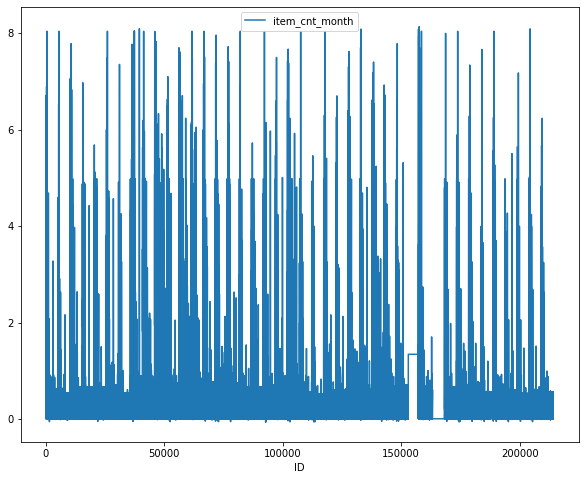

In [278]:
submit.plot('ID', 'item_cnt_month', figsize=(10, 8))

In [279]:
submit.to_csv('../data/processed/submit.csv', index=False)